In [2]:
#Import all modules. Set path for iimporting dishpill_models

import sys
import pickle 
import h5py
import os
import pathlib
import datetime
import numpy as np
import pandas as pd
import scipy
import scipy.stats as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
# import pingouin as pg
pd.options.display.max_columns = 150
%matplotlib inline
sns.set()
pd.set_option('display.max_rows', 250)
sns.set_style("whitegrid")
from scipy.stats import ttest_ind
from statsmodels.stats.anova import AnovaRM
import warnings
warnings.filterwarnings('ignore')
path = "../models"
if not path in sys.path:
    sys.path.append(path)
%reload_ext autoreload
%autoreload 1
# from statannot import add_stat_annotation
import math

#import dishpill_models

/home/aswinpaul/anaconda3/envs/active-inference/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
#group_data takes a pandas data frame and a list of tags, and assigns: whether it is a control trials,
#    a rounded elapsed minute to each trial, and groups into two timepoints or "halfs". 
def group_data(dataframe, tag_list):
    print("Chosen tags are", tag_list)
    df = dataframe
    mask = df['tag'].isin(tag_list)
    df = df[mask]
    group = df['tag'].str.contains('ctl', case = False)
    df['group'] = group.astype(int)
    halfmask = df['elapse_seconds']>t1
    df['elapse_minute_rounded'] = np.int32(df['elapse_seconds'] / 60.)
    df.loc[:,'half'] = halfmask
    df["half"] = df["half"].astype(int)
    
    #df = df[df['hit_count']>0]
    df
    return df

In [5]:
#To determine whether an outlier exists in a given column of data

def is_outlier(s):
    lower_limit = s.mean() - (s.std() * 3.5)
    upper_limit = s.mean() + (s.std() * 3.5)
    return ~s.between(lower_limit, upper_limit)

In [6]:
#use this to find unique ids generated by error as part of a false start.  

def find_unique_ids(ids):
    counts = {}
    for x in ids:
        # .get(x, 0) returns a default of 0 so you don't have to do if x in counts
        counts[x] = counts.get(x, 0) + 1
    return [key for key, value in counts.items() if value == 1]

In [7]:
def normalize(x, col_max):
    if x == -1:
        return np.nan
    else:
        return x/col_max

## Load a=Data

In [8]:
df = pd.read_csv('in_vitro_cells_sentience.csv')

df99 = pd.concat([df])
# df99 = pd.concat([dqn, a2c, ppo])
df99['long_rally']= np.where((df99['hit_count'] >= 3), 1, 0)
df99['ace']= np.where((df99['hit_count'] == 0), 1, 0)
df99["number"] = df99.index


## Average number of episodes

In [9]:
df99_count = df99[df99['group']==0|2]
df99_count=df99_count[df99_count['chip_id']!= 7282]
df_count = df99_count.groupby(['chip_id', 'date','session_num','tag','group']).size().sort_values(ascending=False).reset_index(name='count')



In [10]:
#Group into minutes and take the mean. Filter out data where errors in collection or cell
# activity have been noted. Typically this is when testing was done on chips that never displayed 
#suitable activity but we wanted to investigate for a different reason or when a chip
#was faulty. Note that here most filtered (both rest and active sessions) are from a single tag where
#cells never displayed any robust activity. in-silico sessions removed are 1) due to faulty record and 
#2) due to the wrong tag being put in on one nuc so it was testing something else. 


df2 = df99.groupby(['group', 'tag', 'chip_id', 'date', 'session_num', 'half', 'elapse_minute_rounded']).mean(numeric_only = True)



In [11]:
#to analyse by timepoint we then reset the index and group it by the half we defined earlier. 

df4 = df2.reset_index()
df5 = df4.groupby(['group', 'tag', 'chip_id', 'date', 'session_num', 'half']).mean()

# We then reset the index again to get a single index dataframe and assign a unique id to each chip
df4 = df5.reset_index()
df4["id"] = ((df4['chip_id']).astype(str)) + ((df4['date']).astype(str)) +((df4['session_num']).astype(str))

#Create a string name for each group for easier access

df4['group_name'] = 99
df4['group_name'] = np.where((df4['group']== 0), "MCC", df4['group_name'])
df4['group_name'] = np.where((df4['group']== 1), "CTL", df4['group_name'])
df4['group_name'] = np.where((df4['group']== 2), "HCC", df4['group_name'])
df4['group_name'] = np.where((df4['group']== 3), "RST", df4['group_name'])
df4['group_name'] = np.where((df4['group']== 4), "IS", df4['group_name'])


In [12]:
check = df4.groupby(['group', 'half']).mean(numeric_only = True)


In [13]:
#check for false starts that have no input in second half. 
false_starts = find_unique_ids(df4['id'])
for x in false_starts:
    df4 = df4[df4.id != x]
    

In [14]:
#group all the control groups and group the active experimental groups, perform t-test. 
df3 = df4.groupby(['group', 'tag', 'chip_id', 'date', 'session_num', 'half']).mean(numeric_only = True)
control = df3.drop(index = (0,))
control = control.drop(index = (2,))
exp = df3.drop(index = (1,))
exp = exp.drop(index = (3,))
exp = exp.drop(index = (4,))

hc_t = stats.ttest_ind(control['hit_count'], exp['hit_count'])
ace_t = stats.ttest_ind(control['ace'], exp['ace'])
lr_t = stats.ttest_ind(control['long_rally'], exp['long_rally'])

#Group by treatment and half for each treatment. 

control0 = df4[(df4.half == 0) & (df4.group == 1)]  
control1 = df4[(df4.half == 1) & (df4.group == 1)]  

prim0 = df4[(df4.half == 0) & (df4.group == 0)]  
prim1 = df4[(df4.half == 1) & (df4.group == 0)]  

hCC0 = df4[(df4.half == 0) & (df4.group == 2)]  
hCC1 = df4[(df4.half == 1) & (df4.group == 2)]  

rest0 = df4[(df4.half == 0) & (df4.group == 3)]  
rest1 = df4[(df4.half == 1) & (df4.group == 3)] 

insil0 = df4[(df4.half == 0) & (df4.group == 4)]  
insil1 = df4[(df4.half == 1) & (df4.group == 4)]  

rl0 = df4[(df4.half == 0) & (df4.group == 5)]  
rl1 = df4[(df4.half == 1) & (df4.group == 5)]  



#repeated measures t-tests for each group

ctl_lr= stats.ttest_rel(control0['long_rally'], control1['long_rally'])
ctl_ace = stats.ttest_rel(control0['ace'], control1['ace'])
ctl_hc = stats.ttest_rel(control0['hit_count'], control1['hit_count'])

prim_lr = stats.ttest_rel(prim0['long_rally'], prim1['long_rally'])
prim_ace = stats.ttest_rel(prim0['ace'], prim1['ace'])
prim_hc = stats.ttest_rel(prim0['hit_count'], prim1['hit_count'])

hCC_lr = stats.ttest_rel(hCC0['long_rally'], hCC1['long_rally'])
hCC_ace = stats.ttest_rel(hCC0['ace'], hCC1['ace'])
hCC_hc = stats.ttest_rel(hCC0['hit_count'], hCC1['hit_count'])

rest_lr = stats.ttest_rel(rest0['long_rally'], rest1['long_rally'])
rest_ace = stats.ttest_rel(rest0['ace'], rest1['ace'])
rest_hc = stats.ttest_rel(rest0['hit_count'], rest1['hit_count'])

insil_lr = stats.ttest_rel(insil0['long_rally'], insil1['long_rally'])
insil_ace = stats.ttest_rel(insil0['ace'], insil1['ace'])
insil_hc = stats.ttest_rel(insil0['hit_count'], insil1['hit_count'])

rl_lr = stats.ttest_rel(rl0['long_rally'], rl1['long_rally'])
rl_ace = stats.ttest_rel(rl0['ace'], rl1['ace'])
rl_hc = stats.ttest_rel(rl0['hit_count'], rl1['hit_count'])


In [15]:
#sort by group to make plotting easier

df4['pltgroup'] = 99
df4['pltgroup'] = np.where((df4['group']== 0), "3", df4['pltgroup'])
df4['pltgroup'] = np.where((df4['group']== 1), "0", df4['pltgroup'])
df4['pltgroup'] = np.where((df4['group']== 2), "4", df4['pltgroup'])
df4['pltgroup'] = np.where((df4['group']== 3), "2", df4['pltgroup'])
df4['pltgroup'] = np.where((df4['group']== 4), "1", df4['pltgroup'])
df4 = df4.sort_values(by=['pltgroup'])

In [16]:
df4['%long_rally'] = df4['long_rally']*100
df4['%ace'] = df4['ace']*100

# Long Rallies

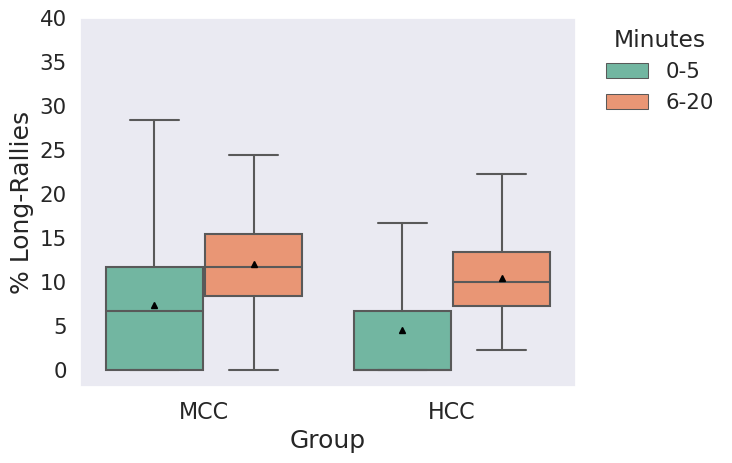

In [17]:
#box plot for long rallies


df_test2 = df4[(df4['group']== 0)|(df4['group']== 2)]


labels = df_test2.group_name.unique()
x_pos = np.arange(len(labels))
x = df_test2['group_name']
y = df_test2['%long_rally']
hue = df_test2['half']
sns.set(style="darkgrid")
sns.set(font_scale=1.4)
ax = sns.boxplot(data=df, x=x, y=y, hue=hue, palette="Set2", showfliers=False, showmeans = True, 
                 meanprops={"markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"5"})
ax.set_xticks(x_pos)
ax.set_xticklabels(labels,fontsize=16)
# ax.set_yticklabels([0,0,5,10,15,20,25,30],fontsize=16)
#ax.set_title('Pong Performance over Time With All Features')
ax.set_ylabel('% Long-Rallies',fontsize = 18)
ax.set_xlabel('Group',fontsize = 18)
ax.grid(False)
ax.legend([0, 1], ["0-5", "6-20"], fontsize = 14)
L = plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), title = "Minutes", borderaxespad=0.1, frameon=False)
L.get_texts()[0].set_text('0-5')
L.get_texts()[1].set_text('6-20')
#ax.set_ylim([0, 2.5])
y, h, col = 30, 0.5, 'k'
x00, x01 = -.2, .2
x10, x11 = .8, 1.2
x20, x21 = 1.8, 2.2
x30, x31 = 2.8, 3.2
x40, x41 = 3.8, 4.2
#Plot t-test between groups


ax.set_ylim([-2, 40])
sns.set(rc={'figure.figsize':(6,6)})
# #= HCC
# % = MCC
#^ = CTL
# @ = Rest
# plt.savefig('long-rallies_RL_vs_SBI.pdf', bbox_inches='tight')

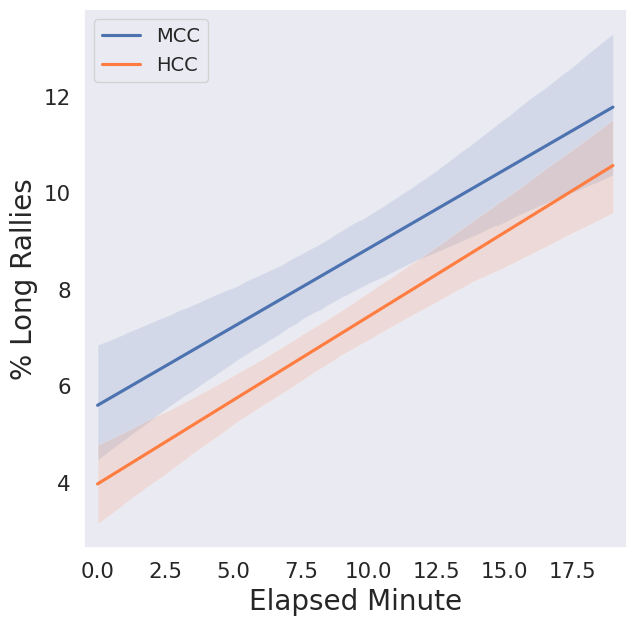

In [18]:
df2 = df99.groupby(['group', 'tag', 'chip_id', 'date', 'session_num', 'elapse_minute_rounded']).mean(numeric_only = True)



cleanDF = df2


lines = cleanDF.reset_index()
control = lines[(lines.group == 0)]
control['Zhit_count'] = (control.hit_count - control.hit_count.mean())/control.hit_count.std(ddof=0) 
control['Zhit_count'] = control['Zhit_count'].abs()
control = control[control.Zhit_count <= 2]


primary = lines[(lines.group == 1)]
primary['Zhit_count'] = (primary.hit_count - primary.hit_count.mean())/primary.hit_count.std(ddof=0) 
primary['Zhit_count'] = primary['Zhit_count'].abs()
primary = primary[primary.Zhit_count <= 2]

human = lines[(lines.group == 2)]
human['Zhit_count'] = (human.hit_count - human.hit_count.mean())/human.hit_count.std(ddof=0) 
human['Zhit_count'] = human['Zhit_count'].abs()
human = human[human.Zhit_count <= 2]

# rest = lines[(lines.group == 3)]
# insilico = lines[(lines.group == 4)]

dqn = lines[(lines.group == 5)]
dqn['Zhit_count'] = (dqn.hit_count - dqn.hit_count.mean())/dqn.hit_count.std(ddof=0) 
dqn['Zhit_count'] = dqn['Zhit_count'].abs()
# dqn['Zhit_count'] = (dqn.hit_count - dqn.hit_count.min())/(dqn.hit_count.max()-dqn.hit_count.min())
dqn = dqn[dqn.Zhit_count <= 2]


a2c = lines[(lines.group == 6)]
a2c['Zhit_count'] = (a2c.hit_count - a2c.hit_count.mean())/a2c.hit_count.std(ddof=0) 
a2c['Zhit_count'] = a2c['Zhit_count'].abs()
a2c = a2c[a2c.Zhit_count <= 2]

ppo = lines[(lines.group == 7)]
ppo['Zhit_count'] = (ppo.hit_count - ppo.hit_count.mean())/ppo.hit_count.std(ddof=0) 
ppo['Zhit_count'] = ppo['Zhit_count'].abs()
ppo = ppo[ppo.Zhit_count <= 2]




control['%long_rally'] = control['long_rally']*100
control['%ace'] = control['ace']*100

human['%long_rally'] = human['long_rally']*100
human['%ace'] = human['ace']*100


px = control[control['elapse_minute_rounded']<20]['elapse_minute_rounded']
py = control[control['elapse_minute_rounded']<20]['%long_rally']
hx = human[human['elapse_minute_rounded']<20]['elapse_minute_rounded']
hy = human[human['elapse_minute_rounded']<20]['%long_rally']

sns.set(font_scale=1.4)
f, ax = plt.subplots(figsize=(7,7))
sns.regplot(x=ax.xaxis.convert_units(px), y=py, x_estimator=np.mean, ci=95, scatter = False, order = 1, label = "MCC",color='b')
sns.regplot(x=ax.xaxis.convert_units(hx), y=hy, x_estimator=np.mean, ci=95, scatter = False, order = 1, label = "HCC",color = "#FF7D40")


sns.set(style="darkgrid")

ax.set_ylabel('% Long Rallies',fontsize =20)
ax.set_xlabel('Elapsed Minute',fontsize =20)
plt.xlim([-0.5, 19.5])
plt.legend(loc='upper left',fontsize =14)
ax.grid(False)

# plt.savefig('regression_lines_LongRallies_RL_v_SBI.pdf', bbox_inches='tight') 


## Stats

In [19]:
from scipy.stats import f_oneway

In [20]:
##Mouse
x = df_test2[(df_test2['group']==0)&(df_test2['half']==0)]['%long_rally']
y = df_test2[(df_test2['group']==0)&(df_test2['half']==1)]['%long_rally']

f_oneway(x,y)

F_onewayResult(statistic=30.025716278401177, pvalue=1.1722371257330123e-07)

In [21]:
##Human
x = df_test2[(df_test2['group']==2)&(df_test2['half']==0)]['%long_rally']
y = df_test2[(df_test2['group']==2)&(df_test2['half']==1)]['%long_rally']

f_oneway(x,y)

F_onewayResult(statistic=122.27736212868112, pvalue=1.5251829098578213e-24)

### Between Groups

In [22]:
##Human vs MCC
x = df_test2[(df_test2['group']==2)&(df_test2['half']==0)]['%long_rally']
y = df_test2[(df_test2['group']==0)&(df_test2['half']==0)]['%long_rally']

f_oneway(x,y)

F_onewayResult(statistic=13.27957679912252, pvalue=0.0003193261113984403)

## Post-hoc

In [27]:
import pingouin as pg
from scipy.spatial.distance import squareform
import scikit_posthocs as sp

In [28]:
# post_hoc_test =  pg.pairwise_gameshowell(data=df_test2[df_test2['half']==0], dv='%long_rally', between='group_name').round(3)
post_hoc_test =  pg.pairwise_tukey(data=df_test2[df_test2['half']==0], dv='%long_rally', between='group_name').round(3)

post_hoc_test

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,HCC,MCC,4.523,7.318,-2.796,0.767,-3.644,0.0,-0.443


# Aces

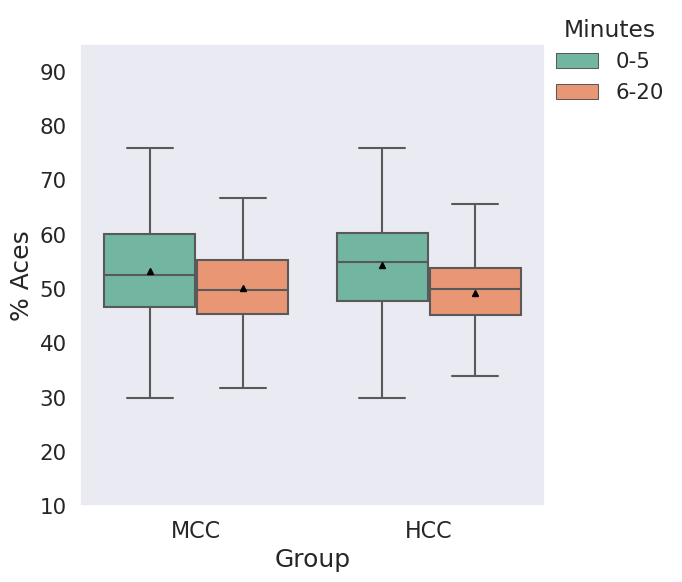

In [29]:
#box plot for aces

df_test2 = df4[(df4['group']== 0)|(df4['group']== 2)]

labels = df_test2.group_name.unique()
x_pos = np.arange(len(labels))
x = df_test2['group_name']
y = df_test2['%ace']
hue = df_test2['half']
sns.set(style="darkgrid")
sns.set(font_scale=1.4)
ax = sns.boxplot(data=df_test2, x=x, y=y, hue=hue, palette="Set2", showfliers=False, showmeans = True, 
                 meanprops={"markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"5"})
ax.set_xticks(x_pos)
ax.set_xticklabels(labels,fontsize = 16)
# ax.set_yticklabels([0,0,10,20,30,40,50,60,70,80],fontsize = 16)
#ax.set_title('Pong Performance over Time With All Features')
ax.set_ylabel('% Aces',fontsize = 18)
ax.set_xlabel('Group',fontsize = 18)
ax.grid(False)
ax.legend([0, 1], ["0-5", "6-20"],fontsize = 14)
L = plt.legend(loc='lower left', bbox_to_anchor=(1, 0.85), title = "Minutes", borderaxespad=0.1, frameon=False)
L.get_texts()[0].set_text('0-5')
L.get_texts()[1].set_text('6-20')
#ax.set_ylim([0, 2.5])
y, h, col = 20, -1.5, 'k'
x00, x01 = -.2, .2
x10, x11 = .8, 1.2
x20, x21 = 1.8, 2.2
x30, x31 = 2.8, 3.2
x40, x41 = 3.8, 4.2


ax.set_ylim([10, 95])
sns.set(rc={'figure.figsize':(6,6)})
# #= HCC
# % = MCC

#^ = CTL
# @ = IS
# plt.savefig('aces_RL_vs_SBI.pdf', bbox_inches='tight') 

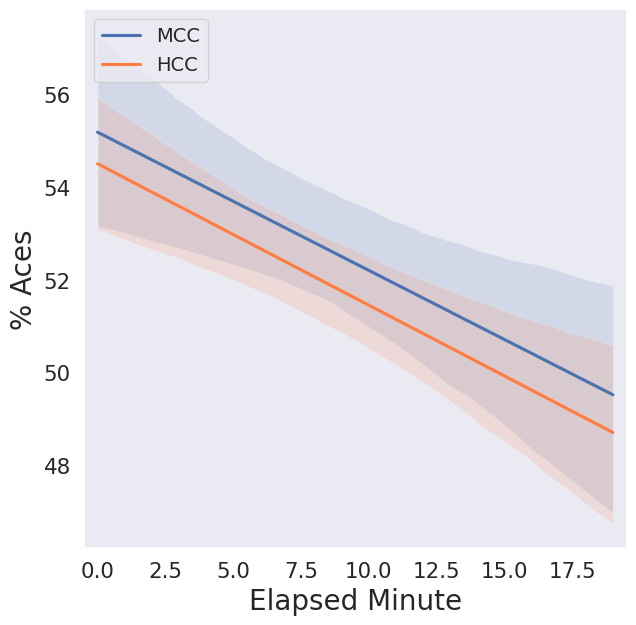

In [30]:
control['%long_rally'] = control['long_rally']*100
control['%ace'] = control['ace']*100

human['%long_rally'] = human['long_rally']*100
human['%ace'] = human['ace']*100



px = control[control['elapse_minute_rounded']<20]['elapse_minute_rounded']
py = control[control['elapse_minute_rounded']<20]['%ace']
hx = human[human['elapse_minute_rounded']<20]['elapse_minute_rounded']
hy = human[human['elapse_minute_rounded']<20]['%ace']

sns.set(font_scale=1.4)
f, ax = plt.subplots(figsize=(7,7))
sns.regplot(x=ax.xaxis.convert_units(px), y=py, x_estimator=np.mean, ci=95, scatter = False, order = 1, label = "MCC",color='b')
sns.regplot(x=ax.xaxis.convert_units(hx), y=hy, x_estimator=np.mean, ci=95, scatter = False, order = 1, label = "HCC",color = "#FF7D40")


sns.set(style="darkgrid")

ax.set_ylabel('% Aces',fontsize =20)
ax.set_xlabel('Elapsed Minute',fontsize =20)
plt.xlim([-0.5, 19.5])
plt.legend(loc='upper left',fontsize =14)
ax.grid(False)

# plt.savefig('regression_lines_Aces_RL_v_SBI.pdf', bbox_inches='tight') 


## Stats

In [31]:
##Mouse
x = df_test2[(df_test2['group']==0)&(df_test2['half']==0)]['%ace']
y = df_test2[(df_test2['group']==0)&(df_test2['half']==1)]['%ace']

f_oneway(x,y)

F_onewayResult(statistic=6.049629930491127, pvalue=0.01468749927305592)

In [32]:
##Human
x = df_test2[(df_test2['group']==2)&(df_test2['half']==0)]['%ace']
y = df_test2[(df_test2['group']==2)&(df_test2['half']==1)]['%ace']

f_oneway(x,y)

F_onewayResult(statistic=32.22581823082425, pvalue=2.907861529424901e-08)

## Post-hoc

In [33]:
# post_hoc_test =  pg.pairwise_gameshowell(data=df_test2[df_test2['half']==0], dv='%ace', between='group_name').round(3)
post_hoc_test =  pg.pairwise_tukey(data=df_test2[df_test2['half']==0], dv='%ace', between='group_name').round(3)
post_hoc_test

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,HCC,MCC,54.382,53.333,1.049,1.245,0.843,0.4,0.102


## Average Rally Length

In [35]:
df2 = df99.groupby(['group', 'tag', 'chip_id', 'date', 'session_num', 'elapse_minute_rounded']).mean(numeric_only = True)



cleanDF = df2


lines = cleanDF.reset_index()
control = lines[(lines.group == 0)]
control['Zhit_count'] = (control.hit_count - control.hit_count.mean())/control.hit_count.std(ddof=0) 
control['Zhit_count'] = control['Zhit_count'].abs()
control = control[control.Zhit_count <= 2]


primary = lines[(lines.group == 1)]
primary['Zhit_count'] = (primary.hit_count - primary.hit_count.mean())/primary.hit_count.std(ddof=0) 
primary['Zhit_count'] = primary['Zhit_count'].abs()
primary = primary[primary.Zhit_count <= 2]

human = lines[(lines.group == 2)]
human['Zhit_count'] = (human.hit_count - human.hit_count.mean())/human.hit_count.std(ddof=0) 
human['Zhit_count'] = human['Zhit_count'].abs()
human = human[human.Zhit_count <= 2]

# rest = lines[(lines.group == 3)]
# insilico = lines[(lines.group == 4)]



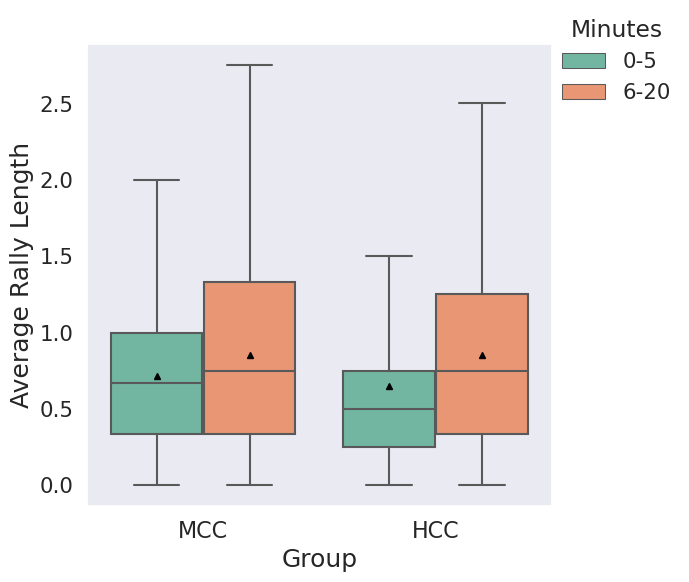

In [36]:
# x = 'group'
# y = 'hit_count'
# hue = 'half'
df_test = pd.concat([control,human])


labels =['MCC', 'HCC'] #df_test.group.unique()
x_pos = np.arange(len(labels))
x = df_test['group']
y = df_test['hit_count']
hue = df_test['half']
sns.set(style="darkgrid")
sns.set(font_scale=1.4)
ax = sns.boxplot(data=df_test, x=x, y=y, hue=hue, palette="Set2", showfliers=False, showmeans = True, 
                 meanprops={"markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"5"})
ax.set_xticks(x_pos)
ax.set_xticklabels(labels,fontsize = 16)
ax.set_ylabel('Average Rally Length',fontsize = 18)
ax.set_xlabel('Group',fontsize = 18)
ax.grid(False)
ax.legend([0, 1], ["0-5", "6-20"],fontsize = 14)
L = plt.legend(loc='lower left', bbox_to_anchor=(1, 0.85), title = "Minutes", borderaxespad=0.1, frameon=False)
L.get_texts()[0].set_text('0-5')
L.get_texts()[1].set_text('6-20')




# ax.set_ylim([10, 95])
sns.set(rc={'figure.figsize':(6,6)})
 
# plt.savefig('BAR_Pong_Over_Time_0,1half_box.pdf', bbox_inches='tight') 

## Stats

In [37]:
##Mouse
x = df_test[(df_test['group']==0)&(df_test['half']==0)]['hit_count']
y = df_test[(df_test['group']==0)&(df_test['half']==1)]['hit_count']

f_oneway(x,y)

F_onewayResult(statistic=20.648112043484204, pvalue=5.854067735447427e-06)

In [38]:
##Human
x = df_test[(df_test['group']==2)&(df_test['half']==0)]['hit_count']
y = df_test[(df_test['group']==2)&(df_test['half']==1)]['hit_count']

f_oneway(x,y)

F_onewayResult(statistic=70.1642508744957, pvalue=7.936362727152438e-17)

In [39]:

df_test['group_name'] = 99
df_test['group_name'] = np.where((df_test['group']== 0), "MCC", df_test['group_name'])
df_test['group_name'] = np.where((df_test['group']== 2), "HCC", df_test['group_name'])
df_test

,group,tag,chip_id,date,session_num,elapse_minute_rounded,Unnamed: 0,elapse_seconds,hit_count,motor_layout,mean_firing,max_firing,var_firing,norm_firing,q95_firing,q90_firing,q75_firing,q50_firing,q25_firing,q10_firing,q05_firing,dct00_firing,dct01_firing,dct02_firing,dct10_firing,dct11_firing,dct12_firing,dct20_firing,dct21_firing,dct22_firing,index,error,half,count,long_rally,ace,number,Zhit_count,group_name
0,0,low_test_rate_code,9323,23/4/2021,0,0,318281.5,31.098600,0.750000,0.0,0.039594,32.466667,0.382248,70.582749,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,256.966667,2.728311,-4.402946,8.730917,1.035975,0.521205,0.42301,0.13998,0.023822,8.0,NaN,0.0,1.0,0.000000,0.500000,15611.5,0.217475,MCC
1,0,low_test_rate_code,9323,23/4/2021,0,1,318285.0,93.790267,1.333333,0.0,0.039594,32.466667,0.382248,70.582749,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,256.966667,2.728311,-4.402946,8.730917,1.035975,0.521205,0.42301,0.13998,0.023822,8.0,NaN,0.0,1.0,0.333333,0.333333,15615.0,0.393605,MCC
2,0,low_test_rate_code,9323,23/4/2021,0,2,318288.5,155.483600,0.500000,0.0,0.039594,32.466667,0.382248,70.582749,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,256.966667,2.728311,-4.402946,8.730917,1.035975,0.521205,0.42301,0.13998,0.023822,8.0,NaN,0.0,1.0,0.000000,0.500000,15618.5,0.479366,MCC
3,0,low_test_rate_code,9323,23/4/2021,0,3,318292.5,213.698600,0.250000,0.0,0.039594,32.466667,0.382248,70.582749,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,256.966667,2.728311,-4.402946,8.730917,1.035975,0.521205,0.42301,0.13998,0.023822,8.0,NaN,0.0,1.0,0.000000,0.750000,15622.5,0.741257,MCC
4,0,low_test_rate_code,9323,23/4/2021,0,4,318296.0,274.900267,1.000000,0.0,0.039594,32.466667,0.382248,70.582749,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,256.966667,2.728311,-4.402946,8.730917,1.035975,0.521205,0.42301,0.13998,0.023822,8.0,NaN,0.0,1.0,0.000000,0.333333,15626.0,0.044417,MCC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7543,2,tdt_predictable_stim_test_no_random_3,8790,1/3/2021,2,15,450988.5,931.469225,1.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.000000,0.250000,28280.5,0.021040,HCC
7544,2,tdt_predictable_stim_test_no_random_3,8790,1/3/2021,2,16,450992.0,985.776133,0.666667,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.000000,0.666667,28284.0,0.211192,HCC
7545,2,tdt_predictable_stim_test_no_random_3,8790,1/3/2021,2,17,450995.0,1047.497983,1.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.000000,0.333333,28287.0,0.021040,HCC
7546,2,tdt_predictable_stim_test_no_random_3,8790,1/3/2021,2,18,450998.0,1095.456200,0.666667,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.000000,0.333333,28290.0,0.211192,HCC


## Post-hoc

In [40]:
# post_hoc_test =  pg.pairwise_gameshowell(data=df_test[df_test['half']==0], dv='hit_count', between='group_name').round(3)
post_hoc_test =  pg.pairwise_tukey(data=df_test[df_test['half']==0], dv='hit_count', between='group_name').round(3)
post_hoc_test

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,HCC,MCC,0.651,0.716,-0.065,0.027,-2.457,0.014,-0.135


## Relative Imporvement

In [42]:
#normalises only by group
filtdf = df4.groupby(['group_name', "pltgroup", 'tag', 'chip_id', 'date', 'session_num', 'half']).mean(numeric_only = True)
data = filtdf[['hit_count']].copy()
data = data.unstack(level=6)
data=data.sort_values(by=["pltgroup"])
#data[('hit_count', 1)] = data[('hit_count', 1)].fillna(method='ffill', inplace=False)
#data = data.dropna()
data["normhc"] = ((data[('hit_count', 1)] - data[('hit_count', 0)]) / data[('hit_count', 0)] ) *100
data = data.reset_index()

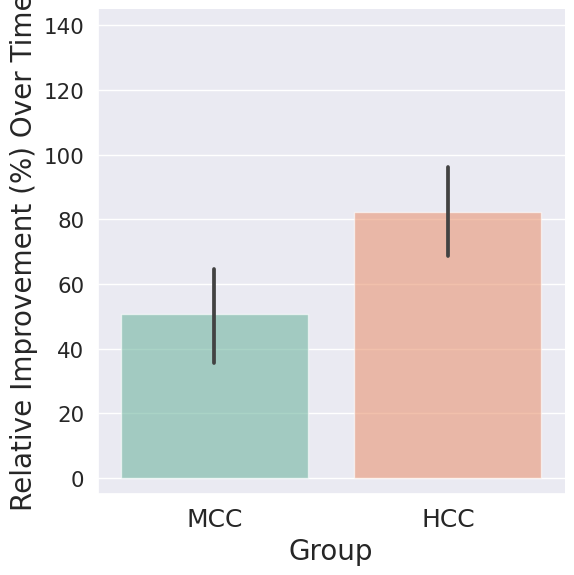

In [43]:
#bar graphs for hit count
data2 = data[(data['group_name']== 'MCC')|(data['group_name']== 'HCC')]

x = 'group_name'
y = 'normhc'
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(5,8)})
sns.set(font_scale=1.4)
ax = sns.catplot(data=data2, kind="bar",x=x, y=y, ci=95, palette="Set2", alpha=.6, height=6)

ax.set_axis_labels("Group", "Relative Improvement (%) Over Time",  fontsize = 20)
ax.set_xticklabels(["MCC", "HCC"],  fontsize = 18)

ax.set(ylim=(-5, 145))
# plt.savefig('Rel_Improvement_RL_vs_SBI.pdf', bbox_inches='tight')  


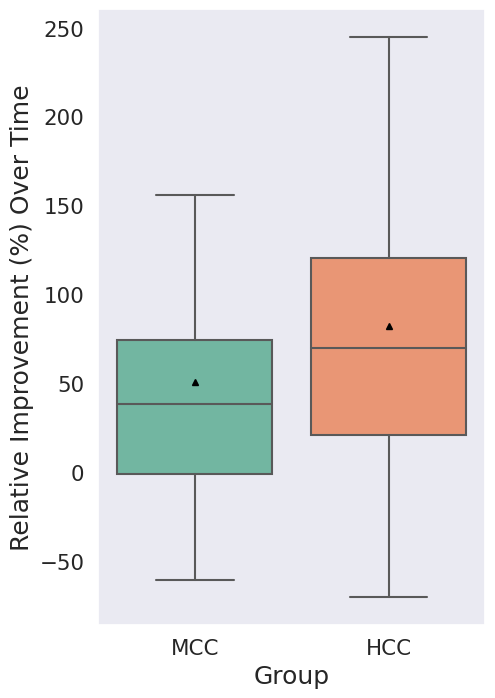

In [44]:
data2 = data[(data['group_name']== 'MCC')|(data['group_name']== 'HCC')]


x = 'group_name'
y = 'normhc'
# hue = df_test2['half']
sns.set(style="darkgrid")
sns.set(font_scale=1.4)
ax = sns.boxplot(data=data2, x=x, y=y, palette="Set2", showfliers=False, showmeans = True, 
                 meanprops={"markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"5"})
ax.set_ylabel('Relative Improvement (%) Over Time',fontsize = 18)
ax.set_xlabel('Group',fontsize = 18)
ax.grid(False)


# ax.set_ylim([10, 95])
sns.set(rc={'figure.figsize':(6,6)})

# plt.savefig('Rel_Improvement_RL_vs_SBI_box.pdf', bbox_inches='tight') 

### Stats

In [45]:
data2.reset_index()
pg.anova(data=data2, dv=('normhc'), between='group_name',detailed = True, effsize = 'np2').round(3)

,Source,SS,DF,MS,F,p-unc,np2
0,group_name,66410.632,1,66410.632,7.845,0.005,0.027
1,Within,2387251.868,282,8465.432,NaN,NaN,NaN


## Post-hoc

In [46]:
post_hoc_test =  pg.pairwise_gameshowell(data=data2, dv='normhc', between='group_name').round(3)

# post_hoc_test =  pg.pairwise_tukey(data=data2, dv='normhc', between='group_name').round(3)
post_hoc_test



,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,HCC,MCC,82.147,50.755,31.391,10.731,2.925,262.994,0.004,0.34


## Regression Plots

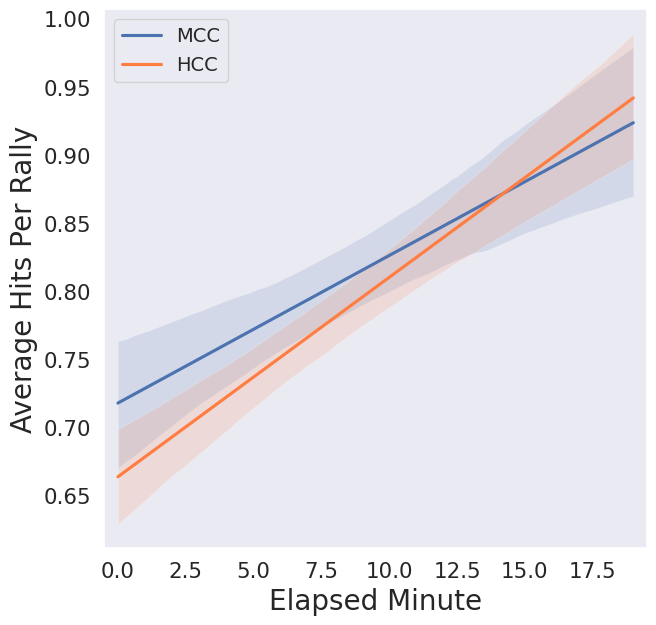

In [47]:
px = control[control['elapse_minute_rounded']<20]['elapse_minute_rounded']
py = control[control['elapse_minute_rounded']<20]['hit_count']
hx = human[human['elapse_minute_rounded']<20]['elapse_minute_rounded']
hy = human[human['elapse_minute_rounded']<20]['hit_count']

sns.set(font_scale=1.4)
f, ax = plt.subplots(figsize=(7,7))
sns.regplot(x=ax.xaxis.convert_units(px), y=py, x_estimator=np.mean, ci=95, scatter = False, order = 1, label = "MCC",color='b')
sns.regplot(x=ax.xaxis.convert_units(hx), y=hy, x_estimator=np.mean, ci=95, scatter = False, order = 1, label = "HCC",color = "#FF7D40")


sns.set(style="darkgrid")

ax.set_ylabel('Average Hits Per Rally',fontsize =20)
ax.set_xlabel('Elapsed Minute',fontsize =20)
plt.xlim([-0.5, 19.5])
plt.legend(loc='upper left',fontsize =14)
ax.grid(False)

# plt.savefig('regression_lines_RL_v_SBI.pdf', bbox_inches='tight') 

#